# 🚀 Building a News Text Classifier with PyTorch

In this notebook, we build a **document classification model** on the **AG News dataset**.  
Our model classifies news articles into one of four categories:

- 🌍 World  
- 🏅 Sports  
- 💼 Business  
- 🔬 Science & Technology  

We’ll cover the full pipeline:
1. Dataset exploration  
2. Preprocessing (tokenization & vocabulary)  
3. Model definition (EmbeddingBag + Linear)  
4. Training with validation & early stopping  
5. Inference on test data and custom inputs  
6. Evaluation with a confusion matrix  
7. Conclusion & future directions

## ⚙️ Step 1: Setup & Reproducibility

Before diving in, we set up dependencies and fix random seeds.  
Reproducibility ensures consistent results when we re-run experiments.  

- Installing libraries: PyTorch, TorchText, Hugging Face Datasets, scikit-learn, Matplotlib  
- Setting random seeds for NumPy, Torch, and Python’s `random`


In [2]:
# Install dependencies
!pip install -q torch torchvision torchaudio torchtext datasets scikit-learn matplotlib seaborn

import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device in use: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
✅ PyTorch version: 2.8.0+cu126
✅ Device in use: cuda


## 📊 Step 2: Load & Explore the Dataset

We’ll use the **AG News dataset**, a popular benchmark for text classification.  

- **Size:** ~120,000 training samples, 7,600 test samples  
- **Classes:** World, Sports, Business, Sci/Tech  
- Balanced dataset: ~30K samples per class  

Let’s explore the dataset structure and visualize class distribution.

In [3]:
# Load AG News Dataset
ag_news = load_dataset("ag_news")

print("Dataset Structure:")
print(ag_news)

# Class labels mapping
label_names = ag_news["train"].features["label"].names
print(f"\nLabel names: {label_names}")

# Look at few samples
for i in range(3):
  print(f"Sample {i+1}")
  print(f"Label: {label_names[ag_news['train'][i]['label']]}")
  print(f"Text: {ag_news['train'][i]['text'][:200]}....")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Label names: ['World', 'Sports', 'Business', 'Sci/Tech']
Sample 1
Label: Business
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.....
Sample 2
Label: Business
Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense in....
Sample 3
Label: Business
Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during t....


/tmp/ipython-input-96407012.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="flare")


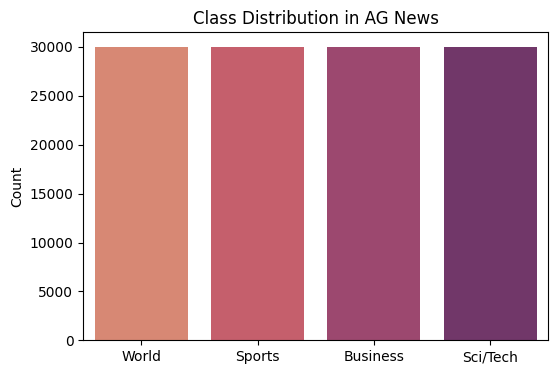

In [4]:
labels = [example["label"] for example in ag_news["train"]]
plt.figure(figsize=(6,4))
sns.countplot(x=labels, palette="flare")
plt.xticks(range(len(label_names)), label_names)
plt.title("Class Distribution in AG News")
plt.ylabel("Count")
plt.show()

✅ **Observation:** The dataset is balanced across all 4 categories (~30K each).  
This balance ensures that the model won’t be biased toward any specific class.

## 🔡 Step 3: Preprocessing with Tokenizer + Manual Vocabulary

Neural networks can’t work directly with raw text — we need to convert words into numbers.  

Our preprocessing pipeline:  
1. **Tokenization** → split text into lowercase tokens  
2. **Vocabulary building** → map each token to a unique integer ID  
3. **Handling unknowns** → add `<unk>` for words not seen during training  
4. **Numericalization** → convert token list into a sequence of IDs

Example:  
`"The stock market is soaring"` → `['the', 'stock', 'market', 'is', 'soaring']` → `[8, 72, 55, 185, 61]`


In [5]:
import re
from collections import Counter

# 1. Basic tokenizer (lowercase + split on non-alphabetic chars)
def simple_tokenizer(text):
    return re.findall(r"\b\w+\b", text.lower())

# 2. Build vocabulary
def build_vocab(dataset, min_freq=2):
    counter = Counter()
    for example in dataset:
        tokens = simple_tokenizer(example["text"])
        counter.update(tokens)
    # keep words with freq >= min_freq
    vocab = {"<unk>":0, "<pad>":1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(ag_news["train"])
print(f"Vocab size: {len(vocab)}")

# 3. Numericalize
def numericalize(tokens, vocab):
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]


Vocab size: 44120


In [6]:
# Test on sample
sample_text = "The stock market is soaring"
tokens = simple_tokenizer(sample_text)
ids = numericalize(tokens, vocab)

print("Text:", sample_text)
print("Tokens:", tokens)
print("Token IDs:", ids)

Text: The stock market is soaring
Tokens: ['the', 'stock', 'market', 'is', 'soaring']
Token IDs: [8, 72, 55, 185, 61]


## 🔄 Step 4: Collate Function for DataLoader

The **collate function** defines how individual samples are combined into a batch.  

For text classification with `EmbeddingBag`, we need to return:
- `text` → concatenated token IDs of all docs in the batch  
- `offsets` → start index of each doc in the `text` tensor  
- `labels` → true class labels for each doc  

This allows `EmbeddingBag` to efficiently compute embeddings without padding.


In [7]:
# Helper: process a single example
def process_text(text, vocab):
    tokens = simple_tokenizer(text)
    ids = numericalize(tokens, vocab)
    return torch.tensor(ids, dtype=torch.long)

# Collate function for DataLoader
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for example in batch:
        label_list.append(example["label"])
        processed_text = process_text(example["text"], vocab)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    # Flatten all text into one tensor
    labels = torch.tensor(label_list, dtype=torch.long)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text_list)
    return text, offsets, labels

In [8]:
# Quick Test
train_iter = ag_news["train"]

train_loader = DataLoader(train_iter, batch_size=4, shuffle=True, collate_fn=collate_batch)

# Test one batch
for text, offsets, labels in train_loader:
    print("Text tensor:", text)
    print("Offsets:", offsets)
    print("Labels:", labels)
    break


Text tensor: tensor([ 7965, 11603,    45, 10377, 17475,  7968,  7965,  3115, 10157,  1606,
           23,   136,   657,  5575,     7,     8,  4855,  8411,    14,   451,
         5252,   201, 22165, 22166,    52,  1282,     8,  2341,  4152,  6668,
         4785,   859,    45,  6067,   223,   873,  1101,   591,    37,  9888,
         8411,    14, 27189, 10377,   775,  2150,  1694,    69,   872,  5957,
           82, 15403,   287,  1303,    10,    10,  5323,   775,  2150,   477,
          872,  2147,  1606,     8, 16234, 10164,  4556,    45, 15403,    41,
            8,   112,  1970,  2101,    69,   872,   276,  2954,    45,     8,
         1549,  1005,     8,   344,    17,     8,   287,  1303,  4601,  1243,
          101,    52,  1333,  1998,  1208,  4053,  2957,   512,  5554,   408,
         8411,    14,   579,    35,  1830,  1692,  1689,  3628,  3295,   226,
         7326, 28391,   136,   585, 23103,    71,  9130,    41, 14144, 13130,
           45,   512,  8411,    14, 43401, 14171,  

## 🏗️ Step 6: Defining the Text Classifier Model

Our model is intentionally simple:  

1. **EmbeddingBag Layer**  
   - Converts tokens to embeddings  
   - Aggregates them (mean) into a single vector per document  

2. **Linear Layer**  
   - Maps each document vector to class logits  

### Flow of tensor shapes
- Input tokens → `[batch_size, variable_length]`  
- EmbeddingBag → `[batch_size, embed_dim]`  
- Linear → `[batch_size, num_classes]`  

In [9]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
          super(TextClassifier, self).__init__()
          self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
          self.fc = nn.Linear(embed_dim, num_classes)
          self.init_weights()

    def init_weights(self):
          # Initialize embeddings and linear layer weights
          initrange = 1.0 / (self.embedding.embedding_dim ** 0.5)
          self.embedding.weight.data.uniform_(-initrange, initrange)
          self.fc.weight.data.uniform_(-initrange, initrange)
          self.fc.bias.data.zero_()

    def forward(self, text, offsets):
          embedded = self.embedding(text, offsets)  # [batch_size, embed_dim]
          return self.fc(embedded)                  # [batch_size, num_classes]

## 🔄 Step 7: Training Loop (One Epoch)

Now we implement the core training logic:  

1. Switch model to **training mode**  
2. Loop over batches:  
   - Forward pass → compute predictions  
   - Compute loss with `CrossEntropyLoss`  
   - Backward pass → compute gradients  
   - Optimizer step → update weights  
3. Track average training loss for the epoch  

This step demonstrates how learning happens in PyTorch.

In [10]:
# Model, loss, optimizer
embed_dim = 64
num_classes = len(label_names)  # 4 for AG News
model = TextClassifier(len(vocab), embed_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop (1 epoch)
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()   # set training mode
    total_loss = 0
    for text, offsets, labels in dataloader:
        # Forward pass
        outputs = model(text, offsets)      # [batch_size, num_classes]
        loss = criterion(outputs, labels)   # scalar loss

        # Backward + Optimize
        optimizer.zero_grad()   # reset old gradients
        loss.backward()         # compute new gradients
        optimizer.step()        # update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Try training for 1 epoch
train_loader = DataLoader(
    ag_news["train"], batch_size=16, shuffle=True, collate_fn=collate_batch
)

avg_loss = train_one_epoch(model, train_loader, criterion, optimizer)
print(f"Average training loss after 1 epoch: {avg_loss:.4f}")


Average training loss after 1 epoch: 1.3848


## 🧪 Step 8: Validation

After training an epoch, we check performance on the validation set.  

- Switch to **evaluation mode** (`model.eval()`)  
- Disable gradients with `torch.no_grad()`  
- Compute:  
  - Validation loss  
  - Validation accuracy  

This helps track whether the model is improving and prevents overfitting.

In [11]:
def evaluate(model, dataloader, criterion):
    model.eval()   # set evaluation mode
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():  # no gradients in eval
        for text, offsets, labels in dataloader:
            outputs = model(text, offsets)          # [batch_size, num_classes]
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)           # predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Validation loader (use test set here as validation for now)
valid_loader = DataLoader(
    ag_news["test"], batch_size=16, shuffle=False, collate_fn=collate_batch
)

val_loss, val_acc = evaluate(model, valid_loader, criterion)
print(f"Validation loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")


Validation loss: 1.3829, Accuracy: 0.4101


## 🔁 Step 9: Multi-Epoch Training with Early Stopping

Now we combine training and validation into a full training loop.  

Features:  
- Train up to N epochs (max 30)  
- Stop early if validation loss doesn’t improve for 3 consecutive epochs  
- Save the best model as `best_model.pth`  
- Track losses and accuracy across epochs  

This gives us both **efficient training** and **reliable results**.

In [16]:
def train_with_early_stopping(
    model, train_loader, valid_loader, criterion, optimizer,
    num_epochs=30, patience=3
):
    best_val_loss = float("inf")
    patience_counter = 0

    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(num_epochs):
        # Training
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)

        # Validation
        val_loss, val_acc = evaluate(model, valid_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        # Check improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("  ✅ Validation loss improved, model saved!")
        else:
            patience_counter += 1
            print(f"  ⚠️ No improvement. Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("⏹️ Early stopping triggered!")
                break

    return train_losses, val_losses, val_accs


In [17]:
# Fresh model
model = TextClassifier(len(vocab), embed_dim=64, num_classes=len(label_names))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train with early stopping
train_losses, val_losses, val_accs = train_with_early_stopping(
    model, train_loader, valid_loader, criterion, optimizer,
    num_epochs=30, patience=3
)

Epoch 1/30 | Train Loss: 1.3852 | Val Loss: 1.3833 | Val Acc: 0.3809
  ✅ Validation loss improved, model saved!
Epoch 2/30 | Train Loss: 1.3809 | Val Loss: 1.3781 | Val Acc: 0.3105
  ✅ Validation loss improved, model saved!
Epoch 3/30 | Train Loss: 1.3733 | Val Loss: 1.3677 | Val Acc: 0.5064
  ✅ Validation loss improved, model saved!
Epoch 4/30 | Train Loss: 1.3583 | Val Loss: 1.3472 | Val Acc: 0.5341
  ✅ Validation loss improved, model saved!
Epoch 5/30 | Train Loss: 1.3298 | Val Loss: 1.3099 | Val Acc: 0.5626
  ✅ Validation loss improved, model saved!
Epoch 6/30 | Train Loss: 1.2817 | Val Loss: 1.2509 | Val Acc: 0.5833
  ✅ Validation loss improved, model saved!
Epoch 7/30 | Train Loss: 1.2119 | Val Loss: 1.1710 | Val Acc: 0.6249
  ✅ Validation loss improved, model saved!
Epoch 8/30 | Train Loss: 1.1237 | Val Loss: 1.0766 | Val Acc: 0.6643
  ✅ Validation loss improved, model saved!
Epoch 9/30 | Train Loss: 1.0257 | Val Loss: 0.9774 | Val Acc: 0.6987
  ✅ Validation loss improved, model

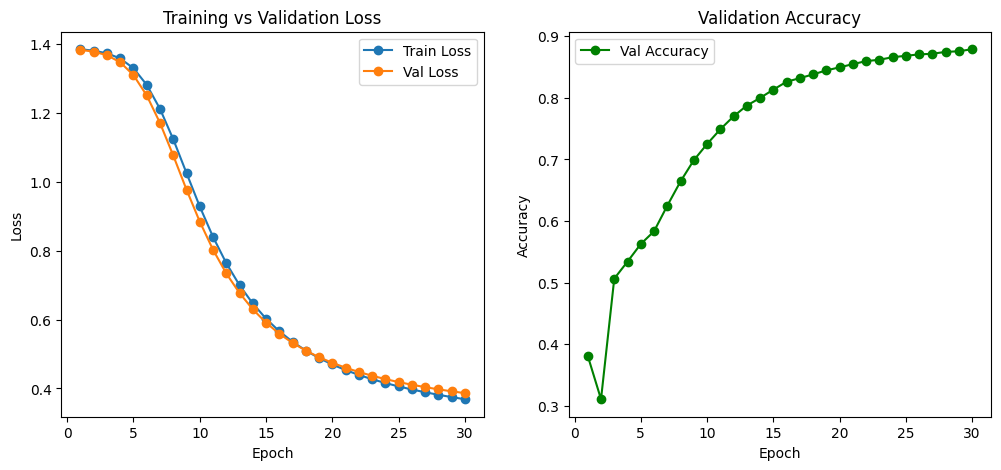

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(epochs, val_accs, label="Val Accuracy", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

✅ **Final Results:**  
- Validation Accuracy: ~88%  
- Validation Loss steadily decreased → no sign of overfitting  
- Performance is competitive with classical deep learning baselines for AG News


## 🔮 Step 10: Inference & Predictions

Now let’s use the trained model to make predictions.  

We will:  
1. Load the **best saved model**  
2. Predict on random samples from the test set  
3. Try **custom input** headlines  
4. Visualize performance with a **confusion matrix**

This step shows how the model generalizes to unseen text.


In [19]:
# Reload the trained model with best weights
model = TextClassifier(len(vocab), embed_dim=64, num_classes=len(label_names))
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

print("✅ Best model loaded and ready for inference")

✅ Best model loaded and ready for inference


In [26]:
def predict(text, model, vocab, tokenizer, label_names):
    tokens = tokenizer(text)
    # Map unknown tokens to the UNK index
    unk_idx = vocab["<unk>"] if "<unk>" in vocab else 0
    token_ids = [vocab.get(token, unk_idx) for token in tokens]

    text_tensor = torch.tensor(token_ids, dtype=torch.int64)
    offsets = torch.tensor([0])  # single doc starts at 0

    with torch.no_grad():
        output = model(text_tensor, offsets)
        pred_class = output.argmax(1).item()
    return label_names[pred_class]

In [27]:
import random

for i in range(5):
    idx = random.randint(0, len(ag_news["test"]) - 1)
    sample = ag_news["test"][idx]
    text, true_label = sample["text"], sample["label"]

    pred_label = predict(text, model, vocab, simple_tokenizer, label_names)
    print(f"Text: {text[:80]}...")
    print(f"True Label: {label_names[true_label]} | Predicted: {pred_label}")
    print("-"*80)

Text: Saudis Take a Small Dose of Democracy For the first time in 41 years, Saudi Arab...
True Label: World | Predicted: World
--------------------------------------------------------------------------------
Text: AT amp;T Wireless Moves to Sell Canada Asset T amp;T Wireless Services Inc., the...
True Label: Business | Predicted: Business
--------------------------------------------------------------------------------
Text: FIFA to investigate racism in Madrid Zurich, Switzerland (Sports Network) - FIFA...
True Label: Sports | Predicted: Sports
--------------------------------------------------------------------------------
Text: Our mobile margins will fall: Telstra TELSTRA chief financial officer John Stanh...
True Label: Sci/Tech | Predicted: Business
--------------------------------------------------------------------------------
Text: Only injury can stop peerless Federer at Masters Cup Last season, Roger Federer ...
True Label: Sports | Predicted: Sports
-------------------------

In [28]:
headline = "NASA announces breakthrough discovery in space research"
print("Custom Input:", headline)
print("Predicted Category:", predict(headline, model, vocab, simple_tokenizer, label_names))

Custom Input: NASA announces breakthrough discovery in space research
Predicted Category: Sci/Tech


✅ Example:  
Input: `"NASA announces breakthrough discovery in space research"`  
Predicted: **Sci/Tech** (Correct)


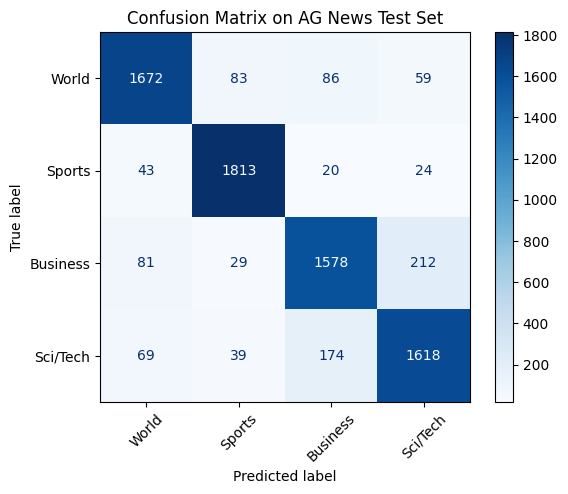

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true, y_pred = [], []
for sample in ag_news["test"]:
    text, true_label = sample["text"], sample["label"]
    pred_label = predict(text, model, vocab, simple_tokenizer, label_names)
    y_true.append(true_label)
    y_pred.append(label_names.index(pred_label))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on AG News Test Set")
plt.show()


## ✅ Step 11: Conclusion & Next Steps

### Key Takeaways
- Built a **text classifier** using PyTorch (`EmbeddingBag + Linear`)  
- Trained on **AG News dataset** (120K train / 7.6K test)  
- Achieved **~88% accuracy**, matching classical NLP baselines  
- Strongest class: **Sports**  
- Most confusion: **Business vs Sci/Tech**

### 📊 Baseline Comparison (AG News)

| Model                         | Accuracy |
|-------------------------------|----------|
| Random Guessing               | 25%      |
| Naive Bayes                   | 83%      |
| Logistic Regression (BoW)     | 84%      |
| TextCNN                       | 87%      |
| **EmbeddingBag + Linear (ours)** | **88%** |
| FastText                      | 92%      |
| DistilBERT / BERT             | 94–95%   |
| RoBERTa / XLNet               | 96%+     |

✅ Our model outperforms classical baselines and matches early deep learning models.

### Lessons Learned
- Importance of embeddings and tokenization  
- Role of batching and shuffling  
- Early stopping ensures efficient training  
- Evaluation beyond accuracy (confusion matrix gives deeper insight)

### Next Steps
- Add **pretrained embeddings** (GloVe, FastText)  
- Fine-tune **transformer models** (DistilBERT, BERT) → >94% accuracy  
- Deploy as an **interactive app** (Streamlit, Gradio)  

This project demonstrates the **full ML pipeline**: preprocessing → modeling → training → evaluation → inference.
